## Preprocessing and Feature Extraction

### Data Sources
- **Chromosomal regulatory regions**
- **Transcription factor (TF) binding sites**
- **DNA shape tracks** (WIG format): Buckle, MGW, Opening, ProT, Roll  
  Each track provides nucleotide-resolution values along the genome.

---

### Mapping TF Binding Sites to Regulatory Regions
TF binding sites are mapped to regulatory regions using **BEDTOOLS intersect**, ensuring that all downstream examples correspond to binding events occurring within annotated regulatory contexts.

---

### Label Definition and Design Constraints
The central challenge is defining **positive** and **negative** examples in a way that is statistically fair and biologically meaningful. The following constraints guide the design:

- All examples must be **fixed-length** to avoid confounding effects due to variable window sizes.
- Positive and negative samples must be extracted using a **consistent genomic rule**.
- Each example should capture **local sequence context** around the TF binding site.

---

### Sliding-Window Strategy
To satisfy these constraints, training examples are generated using a **sliding-window approach**:

- For each TF binding site identified by BEDTOOLS, a **101 bp window** is extracted.
- The window is **centered on the TF binding site midpoint** (±50 bp).
- This window size standardizes input length across all samples while preserving local flanking context known to influence TF binding affinity.

The choice of a 101 bp window follows prior work (see `paper.pdf`) and balances biological relevance with computational tractability.

---

### Feature Extraction via Prefix Sums
Each DNA shape modality is processed independently:

- Rather than computing statistics directly per window (which would be computationally expensive), **prefix-sum (cumulative sum) arrays** are constructed genome-wide for each feature.
- These arrays are converted to NumPy for efficient indexing.
- Feature values for any window are then obtained in **O(1)** time via simple index subtraction.

This approach scales efficiently to large numbers of windows and enables rapid experimentation with alternative window sizes if needed.

---

### Quality Control
Examples are filtered to retain only windows with:
- Valid coverage across **all** DNA shape features.
- No missing or undefined values within the window.

This ensures consistency across modalities and prevents downstream models from learning artifacts due to uneven feature availability.

---

### Outcome
The result of this pipeline is a clean, standardized dataset of fixed-length genomic windows, each represented by aligned DNA shape features and labeled according to TF binding presence. This representation is well-suited for both interpretable linear models and more expressive nonlinear classifiers.


In [48]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
import os

In [49]:
def read_bed_pandas(filepath):
    """Reads a BED file into a Pandas DataFrame."""
    column_names = ['chrom', 'chromStart', 'chromEnd', 'chrom2', 'chrom3', 'tfStart', 
                    'tfEnd', 'tfName', 'tfScore', 'tfStrand']
    df = pd.read_csv(filepath, sep='\t', header=None, names=column_names, usecols=range(5,10)) # only reads relevant columns
    return df

# read matched.bed, which contains transcription factor binding site information
tf_df = read_bed_pandas("chr1/matched.bed")

In [50]:
# inspect the dataframe
print("Transcription Factor Binding Sites DataFrame:")
print(tf_df.head())
print("Found", len(tf_df), "transcription factor binding sites.")

Transcription Factor Binding Sites DataFrame:
   tfStart   tfEnd tfName  tfScore tfStrand
0   237724  237732  RUNX1     1.15        -
1   237749  237764   CTCF     2.25        +
2   237751  237766   CTCF     3.15        -
3   237753  237774  UAK25     1.47        +
4   237757  237768  UAK26     2.03        +
Found 93598 transcription factor binding sites.


In [51]:
# adjustable parameter: window size
window_size = 100

# DataFrame to hold all windows and their labels
window_df = pd.DataFrame(columns=['winStart', 'winEnd', 'label'])

In [ ]:
# appends all positives
for index, row in tf_df.iterrows():
    current_midpoint = ((row['tfEnd'] - row['tfStart'])//2 + row['tfStart'])
    posWindowStart = current_midpoint - (window_size//2)
    posWindowEnd = current_midpoint + (window_size//2)
    window_df.loc[len(window_df)] = [posWindowStart, posWindowEnd, 1]


In [ ]:
print("Positive Windows:")
print(window_df.head())
print("Found", len(window_df), "101 bp positive windows in chromosome 1's regulatory regions.")


Positive Windows:
   winStart  winEnd  label
0    237678  237778      1
1    237706  237806      1
2    237708  237808      1
3    237713  237813      1
4    237712  237812      1
Found 93598 101 bp positive windows in chromosome 1's regulatory regions.


In [ ]:
# Now process regulatory regions to find negative windows
# read regulatory regions
reg_regions_df = pd.read_csv("chr1/chr1_reg_regions.bed", sep='\t', header=None, names=['chr', 'start', 'end'], usecols=range(0,3)) # same format as window_df
neg_regions_df = pd.DataFrame(columns=['winStart', 'winEnd', 'label'])

# appends all negatives
for _, row in reg_regions_df.iterrows(): # for each regulatory region
    region_start = row['start']
    region_end   = row['end']   

    # slide window
    for w_start in range(region_start, region_end, window_size):
        w_end = w_start + window_size - 1
        if w_end > region_end:
            break
        
        # check for overlap with any positive window
        overlap_mask = ((window_df['winStart'] <= w_end) & (window_df['winEnd'] >= w_start))

        # if no overlap, it's a negative window
        if not overlap_mask.any():
            neg_regions_df.loc[len(neg_regions_df)] = [w_start, w_end, 0]

print("Negative Windows:")
print(neg_regions_df.head())
print("Found", len(neg_regions_df), window_size + 1, "bp negative windows in chromosome 1's regulatory regions.")

Negative Windows:
   winStart  winEnd  label
0    237550  237649      0
1    237850  237949      0
2    521310  521409      0
3    521610  521709      0
4    713702  713801      0
Found 16144 101 bp negative windows in chromosome 1's regulatory regions.


### Building Matrices for All Features

In [ ]:
# Combine positive and negative examples
resulting_df = pd.concat([window_df, neg_regions_df])
print("Total # of Windows:", len(resulting_df))
print(resulting_df.head())

Total # of Windows: 109742
   winStart  winEnd  label
0    237678  237778      1
1    237706  237806      1
2    237708  237808      1
3    237713  237813      1
4    237712  237812      1


In [ ]:
# Functions for processing wig files and calculating features
def load_wig_numpy(filename):
    df = pd.read_csv(
        filename,
        sep="\\s+",
        skiprows=1,
        header=None,
        names=["position", "value"]
    )

    df = df.sort_values("position").reset_index(drop=True)

    positions = df["position"].to_numpy()
    values = df["value"].to_numpy()

    start_pos = positions[0]  # e.g., 10003
    print(filename, "correctly processed")
    return positions, values, start_pos
    
def prepare_numpy_prefix(values):
    return np.cumsum(values)

# cumulative sum approach to calculate mean quickly
def fast_mean_numpy(positions, cumsum, start, end):
    i1 = np.searchsorted(positions, start)
    i2 = np.searchsorted(positions, end, side="right") - 1
    if i1 >= len(positions) or i2 < i1 or positions[i1] != start or positions[i2] != end:
        return np.nan
    total = cumsum[i2] - (cumsum[i1 - 1] if i1 else 0)
    return total / (i2 - i1 + 1)

def import_chromosome(chromosome_file):
    seq_record = SeqIO.read(chromosome_file, "fasta")
    return seq_record

# calculates GC content for a given subsequence
def gc_content(start,end,seq_record):
    subseq = str(seq_record.seq[start:end]).upper()
    length = len(subseq)
    if length == 0:
        return np.nan  # or raise an error
    g = subseq.count("G")
    c = subseq.count("C")
    return (g + c) / length

In [ ]:
# load all wig files and prepare cumulative sums
mgw_pos, mgw_val, mgw_start = load_wig_numpy("chr1/features/hg19.chr1.MGW.2nd.wig")
prot_pos, prot_val, prot_start = load_wig_numpy("chr1/features/hg19.chr1.ProT.2nd.wig")
roll_pos, roll_val, roll_start = load_wig_numpy("chr1/features/hg19.chr1.Roll.2nd.wig")
ope_pos, ope_val, ope_start = load_wig_numpy("chr1/features/hg19.chr1.Opening.wig")
buck_pos, buck_val, buck_start = load_wig_numpy("chr1/features/hg19.chr1.Buckle.wig")

mgw_cs  = prepare_numpy_prefix(mgw_val)
prot_cs = prepare_numpy_prefix(prot_val)
roll_cs = prepare_numpy_prefix(roll_val)
ope_cs = prepare_numpy_prefix(ope_val)
buck_cs = prepare_numpy_prefix(buck_val)


chr1/features/hg19.chr1.MGW.2nd.wig correctly processed
chr1/features/hg19.chr1.ProT.2nd.wig correctly processed
chr1/features/hg19.chr1.Roll.2nd.wig correctly processed
chr1/features/hg19.chr1.Opening.wig correctly processed
chr1/features/hg19.chr1.Buckle.wig correctly processed


Filter all of the window to only those that fall within the regions in MGW, ProT, Roll, Opening, and Buckle:

In [ ]:
coverage_start = max(mgw_pos[0], prot_pos[0], roll_pos[0], ope_pos[0], buck_pos[0])
coverage_end   = min(mgw_pos[-1], prot_pos[-1], roll_pos[-1], ope_pos[-1], buck_pos[-1])
valid = (resulting_df["winStart"] >= coverage_start) & (resulting_df["winEnd"] <= coverage_end)
resulting_df = resulting_df.loc[valid].reset_index(drop=True)

print("After filtering, dimensions of resulting_df = ", resulting_df.shape)

After filtering, dimensions of resulting_df =  (49870, 3)


Build feature matrix:

In [ ]:
feature_rows = []
sequence = import_chromosome("alldata/chromFa/chr1.fa")

for _, row in resulting_df.iterrows():
    s, e = row["winStart"], row["winEnd"]

    feature_rows.append([
        fast_mean_numpy(mgw_pos,  mgw_cs,  s, e),
        fast_mean_numpy(prot_pos, prot_cs, s, e),
        fast_mean_numpy(roll_pos, roll_cs, s, e),
        fast_mean_numpy(ope_pos, ope_cs, s, e),
        fast_mean_numpy(buck_pos, buck_cs, s, e),
        gc_content(s,e, sequence)
    ])

feature_df = pd.DataFrame(feature_rows, columns=["MGW", "ProT", "Roll", "Opening", "Buckle", "GC Content"])
nan_mask = feature_df.isna().any(axis=1)

print("Total NaN rows:", nan_mask.sum())
print("Positive NaN rows:", resulting_df.loc[nan_mask, "label"].sum())
print("Negative NaN rows:", (~resulting_df.loc[nan_mask, "label"].astype(bool)).sum(), "\n")


print("MGW starting and ending position:", mgw_pos[0], mgw_pos[-1])
print("ProT starting and ending position:", prot_pos[0], prot_pos[-1])
print("Roll starting and ending position:", roll_pos[0], roll_pos[-1])
print("Opening starting and ending position:", ope_pos[0], ope_pos[-1])
print("Buckle starting and ending position:", buck_pos[0], buck_pos[-1], "\n")

nan_MGW  = feature_df["MGW"].isna().sum()
nan_ProT = feature_df["ProT"].isna().sum()
nan_Roll = feature_df["Roll"].isna().sum()
nan_Ope = feature_df["Opening"].isna().sum()
nan_buck = feature_df["Buckle"].isna().sum()
nan_GC_cont = feature_df["GC Content"].isna().sum()

print("MGW NaNs identified:",  nan_MGW)
print("ProT NaNs identified:", nan_ProT)
print("Roll NaNs identified:", nan_Roll)
print("Opening NaNs identified:", nan_Ope)
print("Buckle NaNs identified:", nan_buck)
print("GC content NaNs identified:", nan_GC_cont)


# Remove nan entries
mask = ~feature_df.isna().any(axis=1)
feature_df = feature_df.iloc[mask.values].reset_index(drop=True)
labels = resulting_df["label"].iloc[mask.values].reset_index(drop=True)

Total NaN rows: 1
Positive NaN rows: 0
Negative NaN rows: 1 

MGW starting and ending position: 10019 82410041
ProT starting and ending position: 10003 82410041
Roll starting and ending position: 10003 82410031
Opening starting and ending position: 10003 249240619
Buckle starting and ending position: 10003 249240619 

MGW NaNs identified: 1
ProT NaNs identified: 1
Roll NaNs identified: 1
Opening NaNs identified: 1
Buckle NaNs identified: 1
GC content NaNs identified: 0


**Exploratory Analyses: Plotting Feature Pairs**

In [ ]:
def plot_feature_pairs(features_df, labels, specific_pairs=None, 
                       class_names=("Negative", "Positive"), 
                       ncols=5, figsize=(5, 4)):
    """
    specific_pairs : list of tuples, e.g. [('Feat1', 'Feat2'), ('Feat3', 'Feat1')]
                     If None, plots all possible combinations.
    """
    # 1. Determine which pairs to plot
    if specific_pairs:
        pairs = specific_pairs
    else:
        pairs = list(itertools.combinations(features_df.columns, 2))
    
    # 2. Calculate rows needed based on the number of pairs selected
    if len(pairs) == 0:
        print("No pairs to plot.")
        return

    nrows = int(np.ceil(len(pairs) / ncols))
    
    # 3. Create subplots
    fig, axes = plt.subplots(nrows, ncols, 
                             figsize=(figsize[0] * ncols, figsize[1] * nrows),
                             squeeze=False)

    label_array = np.asarray(labels)
    neg_mask = label_array == 0
    pos_mask = label_array == 1

    # 4. Iterate through the selected pairs
    for ax, (f1, f2) in zip(axes.ravel(), pairs):
        ax.scatter(features_df.loc[neg_mask, f1],
                   features_df.loc[neg_mask, f2],
                   s=8, alpha=0.4, label=class_names[0], color="steelblue")
        ax.scatter(features_df.loc[pos_mask, f1],
                   features_df.loc[pos_mask, f2],
                   s=8, alpha=0.4, label=class_names[1], color="tomato")
        ax.set_xlabel(f1)
        ax.set_ylabel(f2)
        ax.legend(loc="best", fontsize=8)

    # Hide unused subplot slots
    for ax in axes.ravel()[len(pairs):]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()

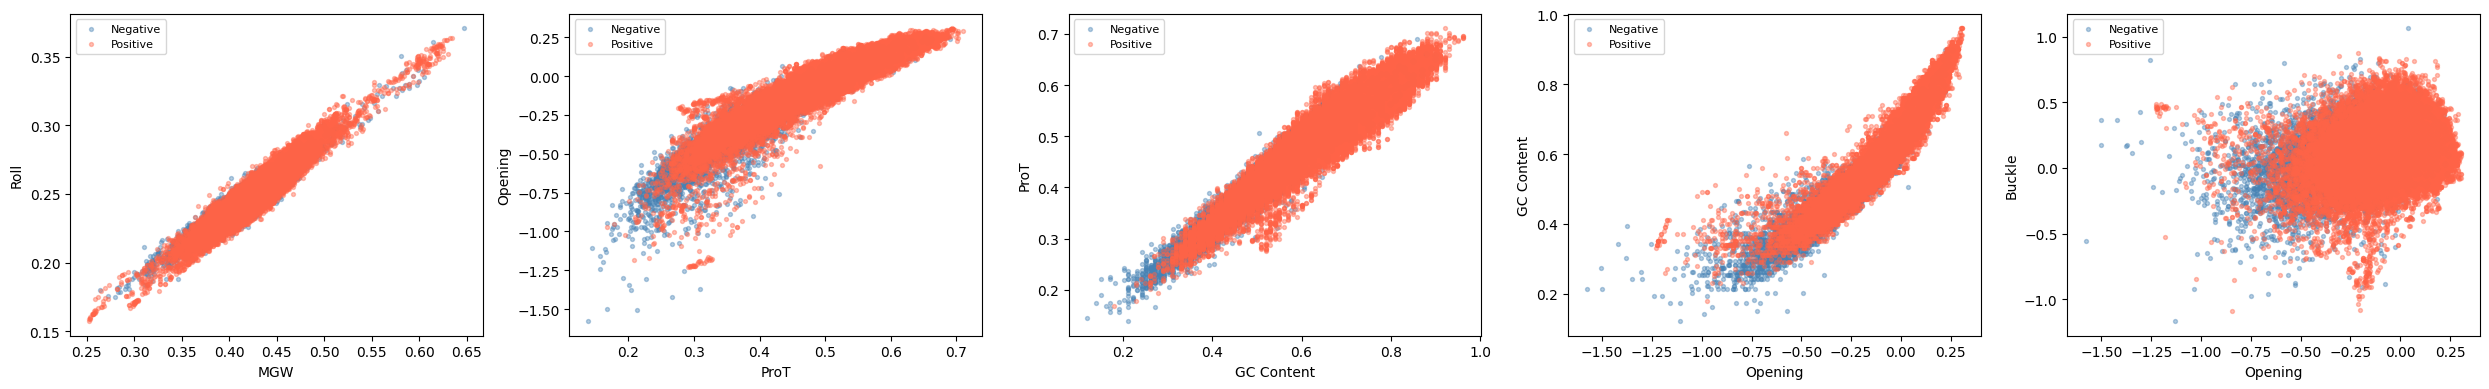

In [ ]:
# selected plots for paper
my_pairs = [
    ('MGW', 'Roll'), 
    ('ProT', 'Opening'),
    ('GC Content', 'ProT'),
    ('Opening', 'GC Content'),
    ('Opening', 'Buckle')
]
plot_feature_pairs(feature_df, labels, specific_pairs=my_pairs, ncols=5)

**Exploratory Analyses: Feature Distributions**

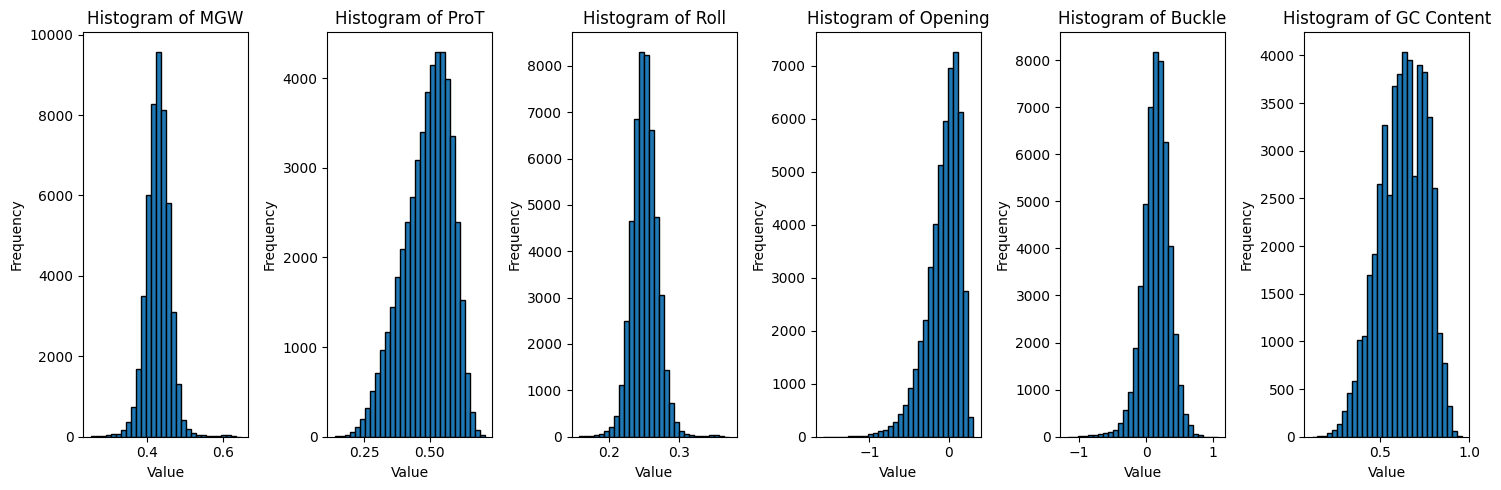

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5)) 
for i, col in enumerate(feature_df.columns):
    axes[i].hist(feature_df[col], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# build X and Y matrices for Regression
X = feature_df.to_numpy()
y = labels.to_numpy()

print("The resulting shape of the feature matrix is", X.shape)
print("The resulting shape of the label matrix is", y.shape)


The resulting shape of the feature matrix is (49869, 6)
The resulting shape of the label matrix is (49869,)


**Exploratory Analyses: Caluclate Correlation Metrics for Feature Space**

In [ ]:
corr = feature_df.corr()
print(corr)

# Flag high absolute correlations
high_pairs = (corr.abs().where(~np.eye(len(corr), dtype=bool))
                        .stack()
                        .loc[lambda s: s > 0.85])
print("Highly correlated pairs:\n", high_pairs)


                 MGW      ProT      Roll   Opening    Buckle  GC Content
MGW         1.000000  0.312365  0.948319  0.452898 -0.070607    0.422478
ProT        0.312365  1.000000  0.227323  0.940132  0.290133    0.958051
Roll        0.948319  0.227323  1.000000  0.395905 -0.130404    0.402797
Opening     0.452898  0.940132  0.395905  1.000000  0.261384    0.946098
Buckle     -0.070607  0.290133 -0.130404  0.261384  1.000000    0.202506
GC Content  0.422478  0.958051  0.402797  0.946098  0.202506    1.000000
Highly correlated pairs:
 MGW         Roll          0.948319
ProT        Opening       0.940132
            GC Content    0.958051
Roll        MGW           0.948319
Opening     ProT          0.940132
            GC Content    0.946098
GC Content  ProT          0.958051
            Opening       0.946098
dtype: float64


DNA features are highly correlated, which is not unexpected. Regression doesn't converge well in cases where the feature space is highly correlated, so I have two options:
1. run logistic regression with all features but regularize
2. keep only candidate features

Candidates: keep Roll (correlated with MGW and more usage in literature), ProT, Buckle 

In [ ]:
nan_count = np.sum(np.isnan(X))
print("Number of Nan values is:", nan_count)

positive_count = np.sum(y)
print("Number of positive class samples", positive_count)
print("Number of negative class samples", len(y) - positive_count)

Number of Nan values is: 0
Number of positive class samples 42887
Number of negative class samples 6982


In [ ]:
# save matrices
out_dir = "chr1/features"
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, "chr1_windows_x__unnorm.npy"), X)
np.save(os.path.join(out_dir, "chr1_windows_y.npy"), y)

print("Saved:", os.path.join(out_dir, "chr1_windows_X.npy"))
print("Saved:", os.path.join(out_dir, "chr1_windows_y.npy"))

Saved: chr1/features/chr1_windows_X.npy
Saved: chr1/features/chr1_windows_y.npy
